# RoughXP Analysis - Preprocessing 

### Author : Matthieu Fraticelli, Emma Ducos - 2023

This code is designed to analyze the data of the RoughXP experiment using EEG signals recorded from BrainProducts R-Net and MyBrainTech Q+


----

*The present code is designed to perform some preprocesing on the data.*

---

### Import required librairies

In [1]:
#To import MNE
import mne

#Other librairies needed
import matplotlib.pyplot as plt
import numpy as np
import os
from mne.preprocessing import (ICA, corrmap, create_ecg_epochs,
                               create_eog_epochs)

In [2]:
#To check the system of MNE
mne.sys_info()

Platform             Windows-10-10.0.19045-SP0
Python               3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]
Executable           C:\Users\mfratice\AppData\Local\anaconda3\envs\IDA\python.exe
CPU                  Intel64 Family 6 Model 154 Stepping 3, GenuineIntel (20 cores)
Memory               31.7 GB

Core
├☑ mne               1.4.0
├☑ numpy             1.23.5 (MKL 2021.4-Product with 14 threads)
├☑ scipy             1.10.1
├☑ matplotlib        3.5.3 (backend=module://matplotlib_inline.backend_inline)
├☑ pooch             1.7.0
└☑ jinja2            3.1.2

Numerical (optional)
├☑ sklearn           1.2.2
├☑ numba             0.56.4
├☑ nibabel           5.1.0
├☑ nilearn           0.10.0
├☑ dipy              1.6.0
├☑ pandas            2.0.0
└☐ unavailable       openmeeg, cupy

Visualization (optional)
├☑ pyvista           0.38.5 (OpenGL 4.5.0 - Build 31.0.101.3959 via Intel(R) Iris(R) Xe Graphics)
├☑ pyvistaqt         0.0.0
├☑ ipyv

---

In [4]:
PROJECT_PATH = 'C:/Users/mfratice/Documents/DATA' #C:/Users/mfratice/Documents/DATA/RESULTS
SOURCE_DATA_PATH = 'C:/Users/mfratice/Documents/DATA/RESULTS'
BIDS_ROOT_PATH = 'C:/Users/mfratice/Documents/DATA/RESULTS' 
#'C:/Users/mfratice/Documents/DATA/BIDS'
RESULTS_PATH = 'C:/Users/mfratice/Documents/DATA/RESULTS_PREPROCESSING'


# select data
sub = "DURJIL"  # subject ID   2021062C003CB
ses = '20230517'  # date of the recording
task = 'roughxp'  # name of the task given in {"roughxp", "roughxprating", "roughxppassive"}
acq = 'RNET'  # name of the device/cap used in {"acticap", "rnet", "qplus"}
run = '001'
modality = 'eeg'  # name of the data modality / BIDS suffix
stim_channel = 'STIM'  # name of the auxiliary channel containing the auditory stimulus
line_freq = 50.

###############################################################
# create a dictionnary to communicate easily between functions
data = dict()
data['sub'] = sub
data['ses'] = ses
data['task'] = task
data['acq'] = acq
data['run'] = run
data['modality'] = modality
data['project_path'] = PROJECT_PATH
data['source_data_path'] = SOURCE_DATA_PATH
data['bids_root_path'] = BIDS_ROOT_PATH
data['line_freq'] = line_freq
data['stim_channel'] = stim_channel
data['results_path'] = RESULTS_PATH

#  open data###############################################################

# BIDS compliant fname
fname_root = f"sub-{data['sub']}_ses-{data['ses']}_task-{data['task']}_acq-{data['acq']}_{data['modality']}"
# BIDS compliant folder path
#bids_path = os.path.join(data['bids_root_path'], f"sub-{data['sub']}", f"ses-{data['ses']}", f"{data['modality']}")

# add the right extension
fname = 'C:/Users/mfratice/Documents/DATA/RESULTS/sub-DURJIL_ses-20230517_task-Default_acq-rnet_run-001_eeg.fif'
#OLD
#fname = os.path.join(bids_path, fname_root + ".fif")

# open .fif data into MNE
raw = mne.io.read_raw(fname, allow_maxshield=False, preload=True, on_split_missing='raise')

Opening raw data file C:/Users/mfratice/Documents/DATA/RESULTS/sub-DURJIL_ses-20230517_task-Default_acq-rnet_run-001_eeg.fif...
Isotrak not found
    Range : 0 ... 957506 =      0.000 ...   957.506 secs
Ready.
Reading 0 ... 957506  =      0.000 ...   957.506 secs...


In [5]:
raw.plot(block=True)

Using qt as 2D backend.
Channels marked as bad:
none


### preprocessing on raw data

In [6]:
# filter line noise 50 Hz
freqs_linenoise = (50, 100, 150, 200, 250, 300, 350, 400, 450)
raw = raw.copy().notch_filter(freqs=freqs_linenoise, picks='all') #picks = 'eeg'

Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 6601 samples (6.601 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    1.0s finished


In [7]:
# %% band pass filter (0.5 - 250 Hz)
raw = raw.copy().filter(l_freq=0.1, h_freq=100, picks='all')

No data channels found. The highpass and lowpass values in the measurement info will not be updated.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 33001 samples (33.001 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:    2.1s finished


In [12]:
raw.plot(block=True)

Channels marked as bad:
none


In [ ]:
# Set montage if needed
# mne.channels.get_builtin_montages()
# montage = mne.channels.make_standard_montage('standard_1020')
# raw.set_montage(montage, verbose=False)

In [ ]:
# ica eog
# ica = ICA()
# ica.fit(raw)

In [ ]:
# ica.plot_sources(raw)

In [ ]:
# ica.exclude = []
# find which ICs match the EOG pattern
# eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name='Fp1')
# ica.exclude = eog_indices

# barplot of ICA component "EOG match" scores
# ica.plot_scores(eog_scores)

# plot diagnostics
# ica.plot_properties(raw, picks=eog_indices)

# plot ICs applied to raw data, with EOG matches highlighted
# ica.plot_sources(raw, show_scrollbars=False)

# plot ICs applied to the averaged EOG epochs, with EOG matches highlighted
# ica.plot_sources(eog_evoked)

In [23]:
events_track, _ = mne.events_from_annotations(raw, regexp='(Track)')
events_track = events_track[:, 0]
event_onsets_of_interest = []
for index in range(0, len(events_track)-1):
    if events_track[index + 1] - events_track[index] > 1000:
        event_onsets_of_interest.append(events_track[index+1])

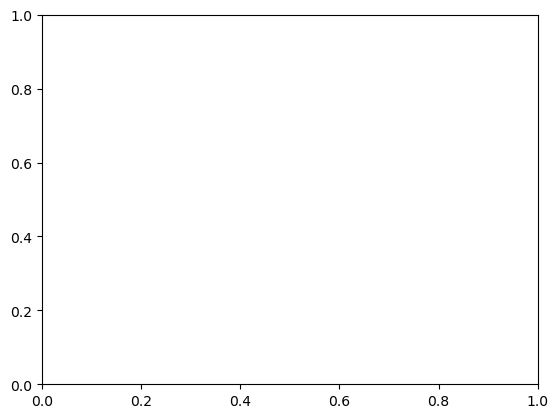

In [24]:
fig, ax = plt.subplots()
ax.vlines(events_track, ymax=1, ymin=0)
ax.vlines(event_onsets_of_interest, ymin=0.5, ymax=1.5, color='k')

In [ ]:
events_track, _ = mne.events_from_annotations(raw, regexp='(Track)')
event_onsets = events_track[:, 0]
event_onsets_of_interest = []
for index in range(0, len(event_onsets)-1):
    if event_onsets[index + 1] - event_onsets[index] > 1000:
        event_onsets_of_interest.append(event_onsets[index+1])

In [ ]:
# TODO find the event_id associated with the Track stim: psychopy ? directly on the stim wave ?
# mne.viz.plot_events(events=event_onsets_of_interest, sfreq=raw.info['sfreq'])

##### find events

In [28]:
# mne.find_event does not work with brainvision data ?
# events, event_id = mne.events_from_annotations(raw, regexp='(Stimulus)')
events, event_id = mne.events_from_annotations(raw)
events = events[np.isin(events[:, 0],event_onsets_of_interest)]

##### epochs

In [29]:
epochs = mne.Epochs(raw, events, tmin=-0.5, 
    tmax=1.5, baseline=(-0.3, -0.1), preload=True)

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
# tentative preprocessing epoch data
# epochs.set_montage(montage, verbose=False)

##### drop channels

In [ ]:
ch_names_to_drop = ['Fp1', 'Fp2', 'F9', 'F10']
epochs.drop_channels(ch_names=ch_names_to_drop)

##### look at the raw data

In [ ]:
raw.compute_psd().plot()

In [ ]:
raw.compute_psd().plot(average=True)

In [ ]:
mne.viz.plot_events(events=events, event_id=event_id, sfreq=raw.info['sfreq'])

In [ ]:
epochs.plot(block=True)

In [ ]:
mne.viz.plot_epochs(epochs)

In [ ]:
epochs.compute_psd().plot()

In [ ]:
epochs.average().plot(gfp=True)

In [ ]:
epochs.average().plot()

##### BIDS

In [ ]:
# create a BIDS compliant filename
filename = f"sub-{data['sub']}_ses-{data['ses']}_task-{data['task']}_acq-{data['acq']}_epoch.fif"
# create a BIDS compliant folder structure
save_path = os.path.join(data['results_path'], f"sub-{data['sub']}", f"ses-{data['ses']}", f"{data['modality']}")
if not os.path.exists(save_path):
    os.makedirs(save_path)
# save as .fif in a BIDS format
raw.save(fname=os.path.join(save_path, filename), overwrite=True)